### * \[important] This notebook is **only for Colab-execution**, please use colaboratory to test following codes.
### * \[important] Change runtime type to GPU first & execute following cells
### * Official Github repository & documents @ https://github.com/keras-team/keras-tuner
### * Keras-tuner Basic tutorial (TF official document) @ https://www.tensorflow.org/tutorials/keras/keras_tuner


<hr>

<br>

## 0. Install Keras-Tuner

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 5.8MB/s 


* Following codes are tested under **Tensorflow==2.3.0 & KerasTuner==1.0.2**
* If some codes are not working, try install tf & kerastuner with above version.

In [ ]:
import tensorflow as tf
import kerastuner as kt

print(tf.__version__)  # 수업시간에는 2.3.0
print(kt.__version__)  # 수업시간에는 1.0.2

2.4.1
1.0.2


<br>

## 1-1. Bayesian HPO with Keras-tuner

In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow import keras 
from tensorflow.keras import layers

import kerastuner as kt
import numpy as np
import IPython

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1_path="/content/drive/MyDrive/genres_v2.csv"
df2_path="/content/drive/MyDrive/playlists.csv"
df = pd.read_csv(df1_path, encoding='utf-8')
df2 = pd.read_csv(df2_path, encoding='utf-8')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# 데이터 가져오기
train_data = np.load('/content/drive/My Drive/semi3/HSK/X_train_pro.npy')
test_data = np.load('/content/drive/My Drive/semi3/HSK/X_test_pro.npy')
train_label = np.load('/content/drive/My Drive/semi3/HSK/y_train_pro.npy')
test_label = np.load('/content/drive/My Drive/semi3/HSK/y_test_pro.npy')

print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(29613, 28)
(12692, 28)
(29613, 15)
(12692, 15)


In [ ]:
train_label[:100]

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# # 첫번째 모델: Spotify_hyper_1
# # 2) Build the hyper-model
# # Available HyperParameter search spaces (https://j.mp/2IXPzh7) : Int, Float, Boolean, Choice, Fixed

# def build_hyper_model(hp):
    
#     model = keras.Sequential()
#     # model.add(layers.Flatten(input_shape=(28, 28))) # change 2-dims MNIST dataset to 1-dim 
        
#     # Tune the number of hidden layer (Choose an optimal value between 1~3)
#     for i in range(hp.Int('num_layers', min_value=3, max_value=7)): 
#         # Tune the number of perceptrons in a dense layer (Choose an optimal value between 32~512) 
#         hp_units = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32) # 32:512 & step 32, all parameter names should be unique (we name the inner parameters 'units_' + str(i))
#         hp_activations = hp.Choice('activation_' + str(i), values=['relu', 'elu'])
#         model.add(layers.Dense(units = hp_units, activation = hp_activations))

#     model.add(layers.Dense(15, activation='softmax')) # class 10 : 0~9

#     # Tune the learning rate for the optimizer (Choose an optimal value from 0.01, 0.001, or 0.0001)
#     hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
#     model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
#                 loss = keras.losses.CategoricalCrossentropy(), # use sparse c.c when our labels are looks like "1" (single integer), not "[1,0,0]" (one-hot vector) (@ http://j.mp/2XS0jmv)
#                 metrics = ['accuracy'])
    
#     return model

In [ ]:
# 두번째 모델: Spotify_hyper_2

def build_hyper_model(hp):
    
    model = keras.Sequential()
    # model.add(layers.Flatten(input_shape=(28, 28))) # change 2-dims MNIST dataset to 1-dim 
        
    # Tune the number of hidden layer (Choose an optimal value between 1~3)
    for i in range(hp.Int('num_layers', min_value=1, max_value=10)): 
        # Tune the number of perceptrons in a dense layer (Choose an optimal value between 32~512) 
        hp_units = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32) # 32:512 & step 32, all parameter names should be unique (we name the inner parameters 'units_' + str(i))
        hp_activations = hp.Choice('activation_' + str(i), values=['relu', 'elu'])
        model.add(layers.Dense(units = hp_units, activation = hp_activations))

    model.add(layers.Dense(15, activation='softmax')) # class 10 : 0~9

    # Tune the learning rate for the optimizer (Choose an optimal value from 0.01, 0.001, or 0.0001)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.CategoricalCrossentropy(), # use sparse c.c when our labels are looks like "1" (single integer), not "[1,0,0]" (one-hot vector) (@ http://j.mp/2XS0jmv)
                metrics = ['accuracy'])
    
    return model

In [ ]:
# 3) Select tuner and compile it
# Available tuners (https://j.mp/39cWz4n) : kt.BayesianOptimization / kt.Hyperband / kt.RandomSearch / kt.Sklearn (https://j.mp/3nSJn8O)

tuner = kt.BayesianOptimization(build_hyper_model,
                                objective = 'val_accuracy', # Hyper-params tuning을 위한 목적함수 설정 (metric to minimize or maximize)
                                max_trials = 10, # 서로 다른 Hyper-params 조합으로 시도할 총 Trial 횟수 설정
                                directory = 'test_prac_dir', # Path to the working directory
                                project_name = 'Spotify_hyper_2') # Name to use as directory name for files saved by this Tuner

# tuner = kt.Hyperband(build_hyper_model,
#                      objective = 'val_accuracy', # Hyper-params tuning을 위한 목적함수 설정 (metric to minimize or maximize)
#                      max_epochs = 5, # 최대 epoch 수 설정, epoch 수 자체도 지정한 최대 횟수 내에서 변화시켜가며 테스트를 진행함 (epochs to train one model) 
#                      directory = 'test_prac_dir', # Path to the working directory
#                      project_name = 'MNIST_hyper_1') # Name to use as directory name for files saved by this Tuner

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
# 4) Train the model

tuner.search(train_data, train_label, epochs=20, validation_data = (test_data, test_label)) # epochs == learning epoch for training a single model(epoch for each trial) 


# # 아래와 같이 별도의 클래스로 콜백을 정의하여 search 함수에서 활용하면 모든 학습 단계 종료 후 학습 중 발생한 출력 결과를 자동으로 지워낼 수 있습니다.
# class ClearTrainingOutput(tf.keras.callbacks.Callback):
#   def on_train_end(*args, **kwargs):
#     IPython.display.clear_output(wait = True)

# tuner.search(x_train, y_train, epochs = 7, validation_data = (x_test, y_test), callbacks = [ClearTrainingOutput()]) # epochs == learning epoch for training a single model 

Trial 10 Complete [00h 01m 16s]
val_accuracy: 0.6514339447021484

Best val_accuracy So Far: 0.6705011129379272
Total elapsed time: 00h 12m 52s


In [ ]:
# 5) Check the result 

tuner.results_summary(num_trials=3) # Show "n" best trial results

Results summary
Results in test_prac_dir/Spotify_hyper_2
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 10
units_0: 512
activation_0: relu
learning_rate: 0.0001
units_1: 512
activation_1: relu
units_2: 32
activation_2: relu
units_3: 32
activation_3: relu
units_4: 32
activation_4: relu
units_5: 32
activation_5: relu
units_6: 32
activation_6: elu
units_7: 32
activation_7: elu
units_8: 512
activation_8: relu
units_9: 512
activation_9: elu
Score: 0.6705011129379272
Trial summary
Hyperparameters:
num_layers: 10
units_0: 512
activation_0: elu
learning_rate: 0.0001
units_1: 512
activation_1: elu
units_2: 32
activation_2: relu
units_3: 32
activation_3: relu
units_4: 512
activation_4: relu
units_5: 32
activation_5: elu
units_6: 32
activation_6: relu
units_7: 32
activation_7: relu
units_8: 32
activation_8: elu
units_9: 512
activation_9: elu
Score: 0.6691616773605347
Trial summary
Hyperparameters:
num_layers: 9
units_0: 256
activat

In [ ]:
# Check top-3 trials' hyper-params

top3_models = tuner.get_best_hyperparameters(num_trials=3)
# print(tuner.get_best_hyperparameters(num_trials=3)[0].space) # 특정 Trial의 Search-space 를 확인할 수 있음
# print(tuner.get_best_hyperparameters(num_trials=3)[0].values) # 특정 Trial에 적용된 Hyper-params를 확인할 수 있음

for idx, model in enumerate(top3_models):
    print('Model performance rank :', idx)
    print(model.values)
    print()


# Check the best trial's hyper-params

best_hps = top3_models[0]

print("""
The hyperparameter search is complete. 
* Optimal # of layers : {}
* Optimal value of the learning-rate : {}""".format(best_hps.get('num_layers'), best_hps.get('learning_rate')))

for layer_num in range(best_hps.get('num_layers')):
    print('Layer {} - # of Perceptrons :'.format(layer_num), best_hps.get('units_' + str(layer_num)))
    print('Layer {} - Applied activation function :'.format(layer_num), best_hps.get('activation_' + str(layer_num)))

Model performance rank : 0
{'num_layers': 10, 'units_0': 512, 'activation_0': 'relu', 'learning_rate': 0.0001, 'units_1': 512, 'activation_1': 'relu', 'units_2': 32, 'activation_2': 'relu', 'units_3': 32, 'activation_3': 'relu', 'units_4': 32, 'activation_4': 'relu', 'units_5': 32, 'activation_5': 'relu', 'units_6': 32, 'activation_6': 'elu', 'units_7': 32, 'activation_7': 'elu', 'units_8': 512, 'activation_8': 'relu', 'units_9': 512, 'activation_9': 'elu'}

Model performance rank : 1
{'num_layers': 10, 'units_0': 512, 'activation_0': 'elu', 'learning_rate': 0.0001, 'units_1': 512, 'activation_1': 'elu', 'units_2': 32, 'activation_2': 'relu', 'units_3': 32, 'activation_3': 'relu', 'units_4': 512, 'activation_4': 'relu', 'units_5': 32, 'activation_5': 'elu', 'units_6': 32, 'activation_6': 'relu', 'units_7': 32, 'activation_7': 'relu', 'units_8': 32, 'activation_8': 'elu', 'units_9': 512, 'activation_9': 'elu'}

Model performance rank : 2
{'num_layers': 9, 'units_0': 256, 'activation_0':

In [ ]:
# Get the best model from trials: accuracy 0.67

models = tuner.get_best_models(num_models=3) # Keras Sequential models
top_model = models[0]
#top_model.summary()
print()

results = top_model.evaluate(test_data, test_label)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])


397/397 [==============================] - 1s 2ms/step - loss: 0.9326 - accuracy: 0.6665
Cross-entropy : 0.929269552230835
Accuracy : 0.6705011129379272


In [ ]:
# We can retrain the model with the optimal hyperparameters from the search.
best_hps = top3_models[0]

# Build the model with the optimal hyperparameters and train it on the data.
model = tuner.hypermodel.build(best_hps)
model.fit(train_data, train_label, epochs=20, validation_data=(test_data, test_label))

results = model.evaluate(test_data, test_label)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

Epoch 1/20
926/926 [==============================] - 4s 4ms/step - loss: 1.8447 - accuracy: 0.3868 - val_loss: 1.1519 - val_accuracy: 0.5990
Epoch 2/20
926/926 [==============================] - 4s 4ms/step - loss: 1.1194 - accuracy: 0.6104 - val_loss: 1.0486 - val_accuracy: 0.6338
Epoch 3/20
926/926 [==============================] - 4s 4ms/step - loss: 1.0288 - accuracy: 0.6385 - val_loss: 1.0064 - val_accuracy: 0.6395
Epoch 4/20
926/926 [==============================] - 4s 4ms/step - loss: 0.9703 - accuracy: 0.6548 - val_loss: 0.9800 - val_accuracy: 0.6514
Epoch 5/20
926/926 [==============================] - 4s 4ms/step - loss: 0.9381 - accuracy: 0.6682 - val_loss: 0.9608 - val_accuracy: 0.6573
Epoch 6/20
926/926 [==============================] - 4s 4ms/step - loss: 0.9239 - accuracy: 0.6666 - val_loss: 0.9514 - val_accuracy: 0.6603
Epoch 7/20
926/926 [==============================] - 4s 4ms/step - loss: 0.8945 - accuracy: 0.6789 - val_loss: 0.9662 - val_accuracy: 0.6562
Epoch 

In [ ]:
# We can also find detailed logs, checkpoints, etc, in the folder "directory/project_name".

# The [test_prac_dir/MNIST_hyper_1] directory contains detailed logs and checkpoints for every trial (model configuration) run during the hyperparameter search. 
# If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. 
# To disable this behavior, pass an additional [overwrite = True] argument while instantiating the tuner.

for trial in tuner.oracle.get_best_trials(num_trials=3):
    print('Trial-score is :', trial.score)
    print('Trial-directory(trial_id) is :', trial.trial_id)
    print()

# tuner.oracle.trials -> get all trial_id 

Trial-score is : 0.6705011129379272
Trial-directory(trial_id) is : 172b075c6e0ed3e48cb768ba8dfaa5e5

Trial-score is : 0.6691616773605347
Trial-directory(trial_id) is : 8fe89f4cf44b83bfd95415d33129cf59

Trial-score is : 0.6667191982269287
Trial-directory(trial_id) is : 9058b8c7d43a7d5c7183fe1b5d71ee90



# 1-2. Keras Tuner - with TopKCategoricalAccuracy(k=3)

In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow import keras 
from tensorflow.keras import layers

import kerastuner as kt
import numpy as np
import IPython

import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 미리 정리한 데이터 불러오기
train_data=np.load('/content/drive/MyDrive/Colab Notebooks/X_train_pro.npy')
test_data=np.load('/content/drive/MyDrive/Colab Notebooks/X_test_pro.npy')
train_label=np.load('/content/drive/MyDrive/Colab Notebooks/y_train_pro.npy')
test_label=np.load('/content/drive/MyDrive/Colab Notebooks/y_test_pro.npy')

print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(29613, 28)
(12692, 28)
(29613, 15)
(12692, 15)


In [ ]:
# TopKCategoricalAccuracy(k=3)를 Keras-tuner에 적용

def build_hyper_model(hp):
    
    model = keras.Sequential()
        
    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):  # 1 ~ 10개의 레이어로 설정
        hp_units = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32) 
        hp_activations = hp.Choice('activation_' + str(i), values=['relu', 'elu'])
        model.add(layers.Dense(units = hp_units, activation = hp_activations))

    model.add(layers.Dense(15, activation='softmax')) # y_data(_label)의 shape 참조

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.CategoricalCrossentropy(), 
                # 아래의 기존 metrics를 TopKCategoricalAccuracy로 수정함.
                metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=3)])
                # metrics = ['accuracy'])
    return model

In [ ]:
tuner = kt.BayesianOptimization(build_hyper_model,
                                objective = 'top_k_categorical_accuracy', # Top 3 정확도로 수정
                                max_trials = 10, 
                                directory = 'test_prac_dir',
                                project_name = 'Spotify_hyper_6') 

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
# 시간이 너무 오래 걸려서.. epochs를 20으로 설정했습니다.
tuner.search(train_data, train_label, epochs=20, validation_data = (test_data, test_label)) 

Trial 10 Complete [00h 01m 11s]
top_k_categorical_accuracy: 0.745348334312439

Best top_k_categorical_accuracy So Far: 0.5344274640083313
Total elapsed time: 00h 11m 40s


In [ ]:
# 가장 성능 좋은 모델 3개 추출
tuner.results_summary(num_trials=3) 

Results summary
Results in test_prac_dir/Spotify_hyper_5
Showing 3 best trials
Objective(name='accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 6
units_0: 96
activation_0: elu
learning_rate: 0.001
units_1: 480
activation_1: relu
units_2: 192
activation_2: elu
units_3: 160
activation_3: relu
units_4: 352
activation_4: elu
units_5: 224
activation_5: elu
units_6: 480
activation_6: relu
units_7: 64
activation_7: relu
units_8: 352
activation_8: relu
Score: 0.9589505195617676
Trial summary
Hyperparameters:
num_layers: 9
units_0: 96
activation_0: relu
learning_rate: 0.001
units_1: 32
activation_1: relu
units_2: 32
activation_2: relu
units_3: 32
activation_3: relu
units_4: 32
activation_4: relu
units_5: 32
activation_5: relu
units_6: 32
activation_6: relu
units_7: 32
activation_7: relu
units_8: 32
activation_8: relu
Score: 0.9314528703689575
Trial summary
Hyperparameters:
num_layers: 1
units_0: 512
activation_0: relu
learning_rate: 0.0001
units_1: 32
activation_1: elu
uni

In [ ]:
# top-3 trials' hyper-params 확인

top3_models = tuner.get_best_hyperparameters(num_trials=3)

for idx, model in enumerate(top3_models):
    print('Model performance rank :', idx)
    print(model.values)
    print()


# the best trial's hyper-params 확인

best_hps = top3_models[0]

print("""
The hyperparameter search is complete. 
* Optimal # of layers : {}
* Optimal value of the learning-rate : {}""".format(best_hps.get('num_layers'), best_hps.get('learning_rate')))

for layer_num in range(best_hps.get('num_layers')):
    print('Layer {} - # of Perceptrons :'.format(layer_num), best_hps.get('units_' + str(layer_num)))
    print('Layer {} - Applied activation function :'.format(layer_num), best_hps.get('activation_' + str(layer_num)))

Model performance rank : 0
{'num_layers': 10, 'units_0': 32, 'activation_0': 'elu', 'learning_rate': 0.0001, 'units_1': 32, 'activation_1': 'elu', 'units_2': 32, 'activation_2': 'relu', 'units_3': 32, 'activation_3': 'elu', 'units_4': 512, 'activation_4': 'elu', 'units_5': 32, 'activation_5': 'relu', 'units_6': 32, 'activation_6': 'relu', 'units_7': 32, 'activation_7': 'relu', 'units_8': 32, 'activation_8': 'relu', 'units_9': 32, 'activation_9': 'relu'}

Model performance rank : 1
{'num_layers': 10, 'units_0': 32, 'activation_0': 'relu', 'learning_rate': 0.0001, 'units_1': 512, 'activation_1': 'elu', 'units_2': 32, 'activation_2': 'relu', 'units_3': 32, 'activation_3': 'elu', 'units_4': 512, 'activation_4': 'elu', 'units_5': 32, 'activation_5': 'elu', 'units_6': 32, 'activation_6': 'elu', 'units_7': 512, 'activation_7': 'relu', 'units_8': 32, 'activation_8': 'relu', 'units_9': 32, 'activation_9': 'relu'}

Model performance rank : 2
{'num_layers': 10, 'units_0': 512, 'activation_0': 'el

In [ ]:
# 가장 성능 좋은 모델로 epochs 20으로 fit
best_hps = top3_models[0]

model = tuner.hypermodel.build(best_hps)
model.fit(train_data, train_label, epochs=20, validation_data=(test_data, test_label))

results = model.evaluate(test_data, test_label)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

Epoch 1/20
926/926 [==============================] - 4s 4ms/step - loss: 2.3889 - top_k_categorical_accuracy: 0.4383 - val_loss: 1.5543 - val_top_k_categorical_accuracy: 0.7769
Epoch 2/20
926/926 [==============================] - 3s 4ms/step - loss: 1.5112 - top_k_categorical_accuracy: 0.7822 - val_loss: 1.3648 - val_top_k_categorical_accuracy: 0.8071
Epoch 3/20
926/926 [==============================] - 3s 4ms/step - loss: 1.3460 - top_k_categorical_accuracy: 0.8132 - val_loss: 1.2802 - val_top_k_categorical_accuracy: 0.8287
Epoch 4/20
926/926 [==============================] - 3s 4ms/step - loss: 1.2568 - top_k_categorical_accuracy: 0.8354 - val_loss: 1.2232 - val_top_k_categorical_accuracy: 0.8442
Epoch 5/20
926/926 [==============================] - 3s 4ms/step - loss: 1.1904 - top_k_categorical_accuracy: 0.8480 - val_loss: 1.1626 - val_top_k_categorical_accuracy: 0.8583
Epoch 6/20
926/926 [==============================] - 3s 4ms/step - loss: 1.1438 - top_k_categorical_accuracy:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# AUC curve를 그리기 위해 기록

history = model.fit(train_data, train_label, batch_size=100, epochs=20, validation_split=0.3)

Epoch 1/20
208/208 [==============================] - 1s 4ms/step - loss: 0.9240 - top_k_categorical_accuracy: 0.9052 - val_loss: 0.9621 - val_top_k_categorical_accuracy: 0.8950
Epoch 2/20
208/208 [==============================] - 1s 4ms/step - loss: 0.9219 - top_k_categorical_accuracy: 0.9075 - val_loss: 0.9679 - val_top_k_categorical_accuracy: 0.8914
Epoch 3/20
208/208 [==============================] - 1s 4ms/step - loss: 0.9206 - top_k_categorical_accuracy: 0.9059 - val_loss: 0.9713 - val_top_k_categorical_accuracy: 0.8930
Epoch 4/20
208/208 [==============================] - 1s 4ms/step - loss: 0.9189 - top_k_categorical_accuracy: 0.9050 - val_loss: 0.9627 - val_top_k_categorical_accuracy: 0.8930
Epoch 5/20
208/208 [==============================] - 1s 4ms/step - loss: 0.9179 - top_k_categorical_accuracy: 0.9052 - val_loss: 0.9639 - val_top_k_categorical_accuracy: 0.8927
Epoch 6/20
208/208 [==============================] - 1s 4ms/step - loss: 0.9172 - top_k_categorical_accuracy:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

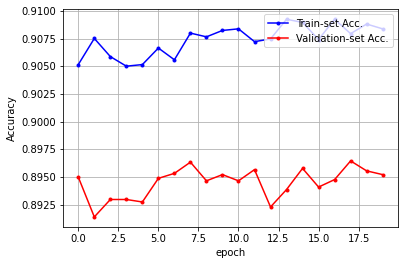

In [ ]:
# top_k_categorical_accuracy를 기준으로 그린 AUC curve 

acc = history.history['top_k_categorical_accuracy']
val_acc = history.history['val_top_k_categorical_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')

# AUC curve 구글 콜랩에서 다운로드
from google.colab import files
plt.savefig("top_k_auc_curve.png")
files.download("top_k_auc_curve.png") 

plt.show()

# 2. Auto Keras

In [ ]:
!pip install autokeras

     |████████████████████████████████| 174kB 17.2MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=1a6fb6f3d8983d822f006cdc38b06f69ac9394f6f29b005af01dfe0037065fe0
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=172a234c3143f2b66645bc7644eddacb2286c6dbec5f79201071cd1bd7de9ff0
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import autokeras as ak

In [ ]:
#https://machinelearningmastery.com/autokeras-for-classification-and-regression/
#https://autokeras.com/tutorial/structured_data_classification/
model = ak.StructuredDataClassifier(max_trials=10) # It searches CNN architectures for the best configuration for the image dataset.
model.fit(train_data, train_label) # time_limit: The time limit for the search in seconds.

accuracy = model.evaluate(test_data, test_label)
result = model.predict(test_data)

print(accuracy)
print(result)

Trial 10 Complete [00h 01m 28s]
val_accuracy: 0.6024402379989624

Best val_accuracy So Far: 0.6193865537643433
Total elapsed time: 00h 40m 03s
Epoch 1/75
926/926 [==============================] - 4s 4ms/step - loss: 2.1198 - accuracy: 0.2964
Epoch 2/75
926/926 [==============================] - 4s 4ms/step - loss: 1.3505 - accuracy: 0.5376
Epoch 3/75
926/926 [==============================] - 4s 4ms/step - loss: 1.2307 - accuracy: 0.5734
Epoch 4/75
926/926 [==============================] - 4s 4ms/step - loss: 1.1700 - accuracy: 0.5905
Epoch 5/75
926/926 [==============================] - 4s 4ms/step - loss: 1.1338 - accuracy: 0.5968
Epoch 6/75
926/926 [==============================] - 4s 4ms/step - loss: 1.1100 - accuracy: 0.6034
Epoch 7/75
926/926 [==============================] - 4s 4ms/step - loss: 1.0927 - accuracy: 0.6080
Epoch 8/75
926/926 [==============================] - 4s 4ms/step - loss: 1.0791 - accuracy: 0.6119
Epoch 9/75
926/926 [==============================] - 4s 